## CoNaLa Dataset Exploration Notebook

In [12]:
import json
import argparse
import code
from pprint import pprint
from termcolor import colored
import re
import random
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Any
from collections import defaultdict
import pydoc
from functools import reduce
import pickle

import nbimporter
from utils_nb import get_all_words_pred

%matplotlib inline

In [2]:
train_file = '../../raw-datasets/conala-corpus/conala-train.json'
test_file  = '../../raw-datasets/conala-corpus/conala-test.json'

In [3]:
keywords = {
    # python libs
    "os"         : ['os.', 'from os import'],
    "(sh|ps)util": ['shutil.', 'psutil.', 'from shutil import', 'from psutil import'],
    "sys"        : ['sys.', 'from sys import'],
    "struct"     : ['struct.', 'from struct import'],
    "subprocess" : ['subprocess.', 'from subprocess import'],
    "date-time"  : ['datetime.', 'calendar.', 'from datetime import', 'from calendar import'],
    "time"       : ['time.', 'from time import'],
    "urllib"     : ['urllib.', 'from urllib import'],
    "regex"      : ['re.', 'from re import'],
    "itertools"  : ['itertools.', 'from itertools import'],
    "random"     : ['random.', 'from random import'],
    "requests"   : ['request.', 'requests.'],
    "io"         : ['open(', '.send('],
    "str-join"   : [".join("],

    # 3rd party libs
    "django"     : ['django'],
    "scipy"      : ['scipy.', 'from scipy import'],
    "numpy"      : ['np.', 'numpy.', 'from numpy import'],
    "pickle"     : ['pickle.', 'from pickle import'],
    "pandas"     : ['pd.', 'df[', 'df.', 'from pandas import', 'dataframe', 'pandas'],
    "matplotlib" : ['plt.' 'fig.', 'ax.', 'import matplotlib', 'from matplotlib import'],
    "networkx"   : ['nx.', 'from networkx import'],
    "gui"        : ['gi.', 'wx.', 'tk.', 'dogtail'],
    "flask"      : ['flask.', 'from flask import'],

    # calls
    "functional" : ['map(', 'filter(', 'reduce(', 'zip(', 'sum(', 'sorted('],
    "print"      : ['print('],
    
    "lambda"     : ['lambda', 'anonymous'],

    # list comprehension
    "list-comp"  : [lambda x: x[0] == '[' and x[-1] == ']'],
    
    # generator
    "generator"  : [lambda x: x[0] == '(' and x[-1] == ')'],
}

def get_intent(ex):
    return ex['rewritten_intent'] if ex['rewritten_intent'] is not None else ex['intent']

def get_unique(xs):
    u, c = np.unique(xs, return_counts=True)
    _c = np.argsort(-c)

    return u[_c], c[_c]

def query_by_key(data: Dict[str, Any], key):
    return [data[i][key] for i in range(len(data))]

def get_by_qid(data: Dict[str, Any], qid: int):
    return list(filter(lambda ex: ex["question_id"] == qid, data))

def get_by_keywords(data: Dict[str, Any]):
    xs = defaultdict(lambda: [])
 
    for q in data:
        found = False
        
        for ks in keywords:
            for k in keywords[ks]:
            
                i = q["intent"].lower()
                ri = q["rewritten_intent"].lower() if q["rewritten_intent"] else None
                s = q["snippet"].lower()
                
                if isinstance(k, str):
                    if (k in i) or (ri and k in ri) or (k in s):
                        xs[ks].append(q)
                        found = True
                
                # lambda predicate
                else:
                    if k(s):
                        xs[ks].append(q)
                        found = True
            
        # other keywords
        if not found:
            xs['other'].append(q)

    return xs

In [4]:
train_data = json.load(open(train_file, "rt"))
test_data = json.load(open(test_file, "rt"))

train_uids, train_cuids = get_unique(query_by_key(train_data, "question_id"))
test_uids, test_cuids = get_unique(query_by_key(test_data, "question_id"))

train_none_rewritten = [x for x in train_data if x['rewritten_intent'] is None]
test_none_rewritten = [x for x in test_data if x['rewritten_intent'] is None]

print(f"[train] {train_uids.size} unique ids")
print(f"[train] null-rewritten {round(100.0*len(train_none_rewritten)/len(train_data),3)}%")
print(f"[test] {test_uids.size} unique ids")
print(f"[test] null-rewritten {round(100.0*len(test_none_rewritten)/len(test_data),3)}%")

[train] 1710 unique ids
[train] null-rewritten 3.321%
[test] 364 unique ids
[test] null-rewritten 4.6%


train-other: 34%
test-other: 33%


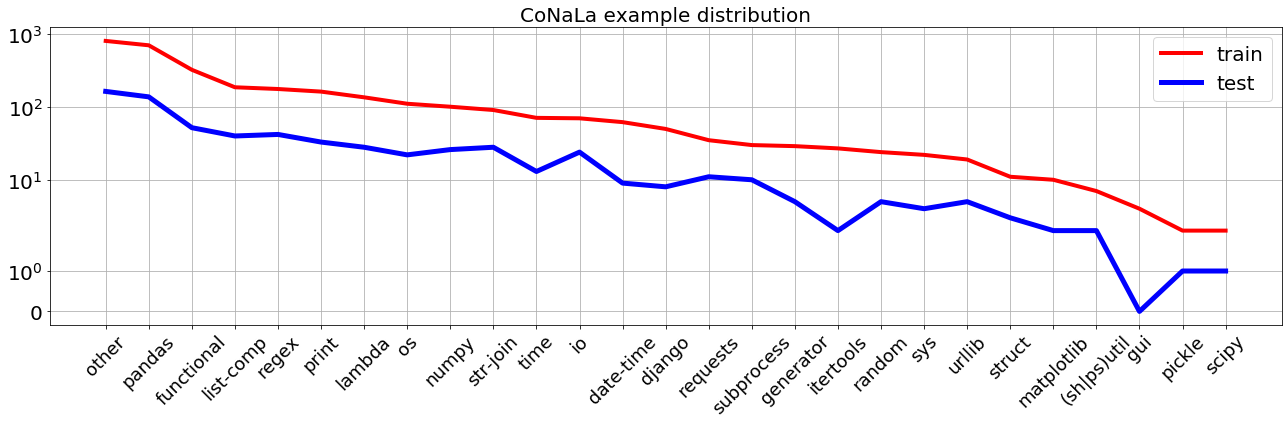

In [5]:
train_xs = get_by_keywords(train_data)
test_xs = get_by_keywords(test_data)

# print("[train]")
# for l, qs in sorted(train_xs.items(), key=lambda k : len(k[1]), reverse=True):
#     print(f"{l} -> {len(qs)}({round(100.0 * len(qs)/len(train_data), 3)}%)")
# print()

# print("[test]")
# for l, qs in sorted(test_xs.items(), key=lambda k : len(k[1]), reverse=True):
#     print(f"{l} -> {len(qs)}({round(100.0 * len(qs)/len(test_data), 3)}%)")

print(f"train-other: {round(100.0 * len(train_xs['other']) / len(train_data))}%")
print(f"test-other: {round(100.0 * len(test_xs['other']) / len(test_data))}%")

s = sorted(train_xs.items(), key=lambda k : len(k[1]), reverse=True)
labels = [x[0] for x in s]

plt.figure(figsize=(int(0.67 * len(labels)), 6))

plt.xticks(range(len(s)), labels, rotation=45, fontsize=18)
plt.yticks(fontsize=20)
plt.yscale('symlog')

plt.plot(range(len(s)), [len(x[1]) for x in s], 'r-', label='train', linewidth=4.0)
plt.plot(range(len(s)), [len(test_xs[k]) for k in labels], 'b-', label='test', linewidth=5.0)
      
    

plt.legend(prop={'size': 20})
plt.grid()
plt.title('CoNaLa example distribution', size=20)
plt.tight_layout()
plt.show()

### Check intent-corpus coverage

In [16]:
pt_emb = pickle.load(open('../../embeddings/glove.6B.200d.txt.pickle', 'rb'))

c = get_all_words_pred(
    corpus='../../corpus/python-stackoverflow/question_words_clean.pickle',
    vocab_size=10000,
    word_predicate=lambda w: w in pt_emb,
    min_freq=1, pt_emb=pt_emb
)

In [18]:
# calculate coverage for all words in intents that are also present in embeddings (i.e. skip var names etc)

xs = [get_intent(train_data[i]).split() for i in range(len(train_data))]
xs = list(reduce(lambda a, b : list(set(a + b)), xs, []))

i = t = 0
ws = []
for w in xs:
    if w not in pt_emb: continue
    
    if w in c:
        i += 1
    else:
        ws += [w]
        
    t += 1
    
print("Intent-corpus coverage", round(i/t, 5))

ws[:10]

Intent-corpus coverage 0.84


['as',
 'comma-separated',
 '2nd',
 'non-zero',
 '77',
 'once',
 '50-100',
 '50',
 'through',
 '3-d']